In [1]:
import pandas as pd

Diabetes Prediction Dataset

In [3]:
data = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/diabetes_prediction_dataset.csv")
len(data)

100000

Splitting the data into training and testing

In [33]:
# Initial Train/Test Split
#data = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/diabetes_prediction_dataset.csv")
# from sklearn.model_selection import train_test_split
#X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
#X_train.to_csv("/Users/anastasiakurakova/Desktop/Data/diabetes_train.csv", encoding='utf-8', index=False)
#X_test.to_csv("/Users/anastasiakurakova/Desktop/Data/diabetes_test.csv", encoding='utf-8', index=False)

In [3]:
#Train/Test datasets
data = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/diabetes/diabetes_train.csv")
X_test = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/diabetes/diabetes_test.csv")

CTGAN is a part of Synthetic Data Vault.

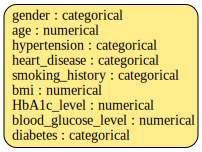

In [4]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)
metadata.visualize()


Running the model

In [5]:
%%time
ctgan = CTGANSynthesizer(metadata, epochs=300, verbose=True)
ctgan.fit(data)


Gen. (-1.90) | Discrim. (0.05): 100%|██████████| 300/300 [23:25<00:00,  4.68s/it] 

CPU times: user 22min 34s, sys: 12min 47s, total: 35min 22s
Wall time: 24min 3s


In [6]:
loss_values = ctgan.get_loss_values()

In [7]:

import plotly.express as px

loss_values_reformatted = pd.melt(
    loss_values,
    id_vars=['Epoch'],
    var_name='Loss Type'
)

fig = px.line(loss_values_reformatted, x="Epoch", y="value", color="Loss Type", title='Epoch vs. Loss')
fig.show()

In [8]:
# Sample Data equal to the size of the training set
samples = ctgan.sample(len(data))

In [54]:
#samples.to_csv("/Users/anastasiakurakova/Desktop/Data/synthetic_diabetes_ctganTSTR.csv", encoding='utf-8', index=False)

In [9]:
samples.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,16.95,0,0,No Info,18.37,6.2,161,1
1,Female,57.10,1,0,former,26.49,4.5,159,0
2,Female,60.79,0,1,never,24.27,3.5,82,0
3,Female,44.59,0,0,No Info,25.36,4.5,83,0
4,Female,14.38,0,0,No Info,17.35,5.8,160,0
5,Female,34.86,0,0,never,27.37,6.6,130,1
6,Male,52.64,1,0,current,46.77,7.2,89,1
7,Female,77.05,0,0,ever,21.94,3.5,89,0
8,Female,72.44,0,0,never,43.94,7.5,236,1
9,Male,43.08,0,0,current,28.43,3.5,85,0


In [10]:
# Checking for duplicates between original and synthetic datasets

common_duplicates = pd.merge(X_test, samples, how='inner')
new = common_duplicates.drop_duplicates()
# Print the common duplicate rows
print("Common Duplicate Rows:")
print(common_duplicates)
print(new)

Common Duplicate Rows:
Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, smoking_history, bmi, HbA1c_level, blood_glucose_level, diabetes]
Index: []
Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, smoking_history, bmi, HbA1c_level, blood_glucose_level, diabetes]
Index: []


### Using Synthetic Data Vault Library for Evaluation

In [11]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

diagnostic = run_diagnostic(
    real_data=X_test,
    synthetic_data=samples,
    metadata=metadata
)
quality_report = evaluate_quality(
    X_test,
    samples,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 36/36 [00:02<00:00, 17.98it/s]

Overall Score: 84.48%

Properties:
- Column Shapes: 87.77%
- Column Pair Trends: 81.19%


In [12]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,gender,TVComplement,0.993100
1,age,KSComplement,0.816462
2,hypertension,TVComplement,0.894550
3,heart_disease,TVComplement,0.846525
4,smoking_history,TVComplement,0.839137
5,bmi,KSComplement,0.879287
6,HbA1c_level,KSComplement,0.896600
7,blood_glucose_level,KSComplement,0.880937
8,diabetes,TVComplement,0.852538


### Calculate Range Coverage and KSComplement for Numerical Variables

In [16]:

from sdmetrics.single_column import RangeCoverage, KSComplement
for i in ['bmi','HbA1c_level']:
  range_cov = RangeCoverage.compute(
      real_data=X_test[i],
      synthetic_data=samples[i]
  )
  ks = KSComplement.compute(
      real_data=X_test[i],
      synthetic_data=samples[i]
  )
  print(f"Range coverage for {i} is: {range_cov}")
  print(f"KSComplement for {i} is: {ks}")

Range coverage for bmi is: 0.6797660818713451
KSComplement for bmi is: 0.8792875
Range coverage for HbA1c_level is: 1.0
KSComplement for HbA1c_level is: 0.8966000000000001


### Calculate Category Coverage and TVComplement for Categorical Variables

In [17]:

from sdmetrics.single_column import CategoryCoverage, TVComplement
for i in ['smoking_history','diabetes']:
  cat_cov = CategoryCoverage.compute(
    real_data=X_test[i],
    synthetic_data=samples[i]
  )
  tv = TVComplement.compute(
      real_data=X_test[i],
      synthetic_data=samples[i]
  )
  print(f"Category coverage for {i} is: {cat_cov}")
  print(f"TVComplement for {i} is: {tv}")


Category coverage for smoking_history is: 1.0
TVComplement for smoking_history is: 0.8391375
Category coverage for diabetes is: 1.0
TVComplement for diabetes is: 0.8525375000000001


### Using Table Evaluator for Evaluation

(20000, 9) (80000, 9)


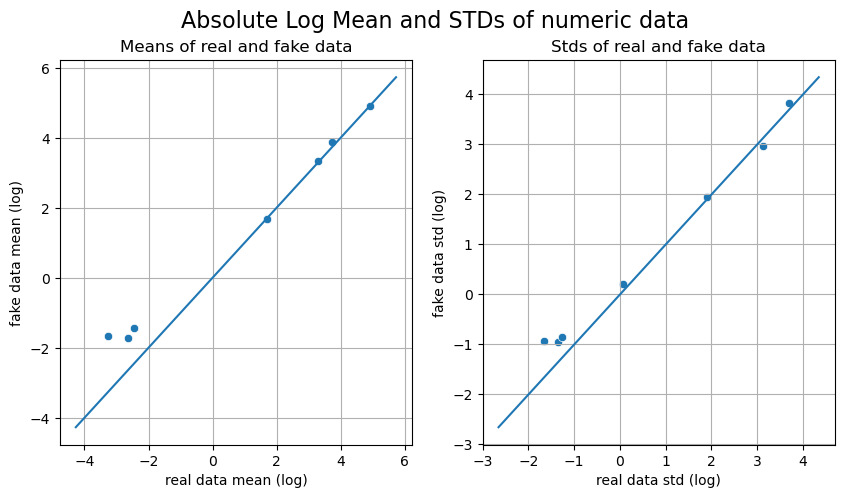

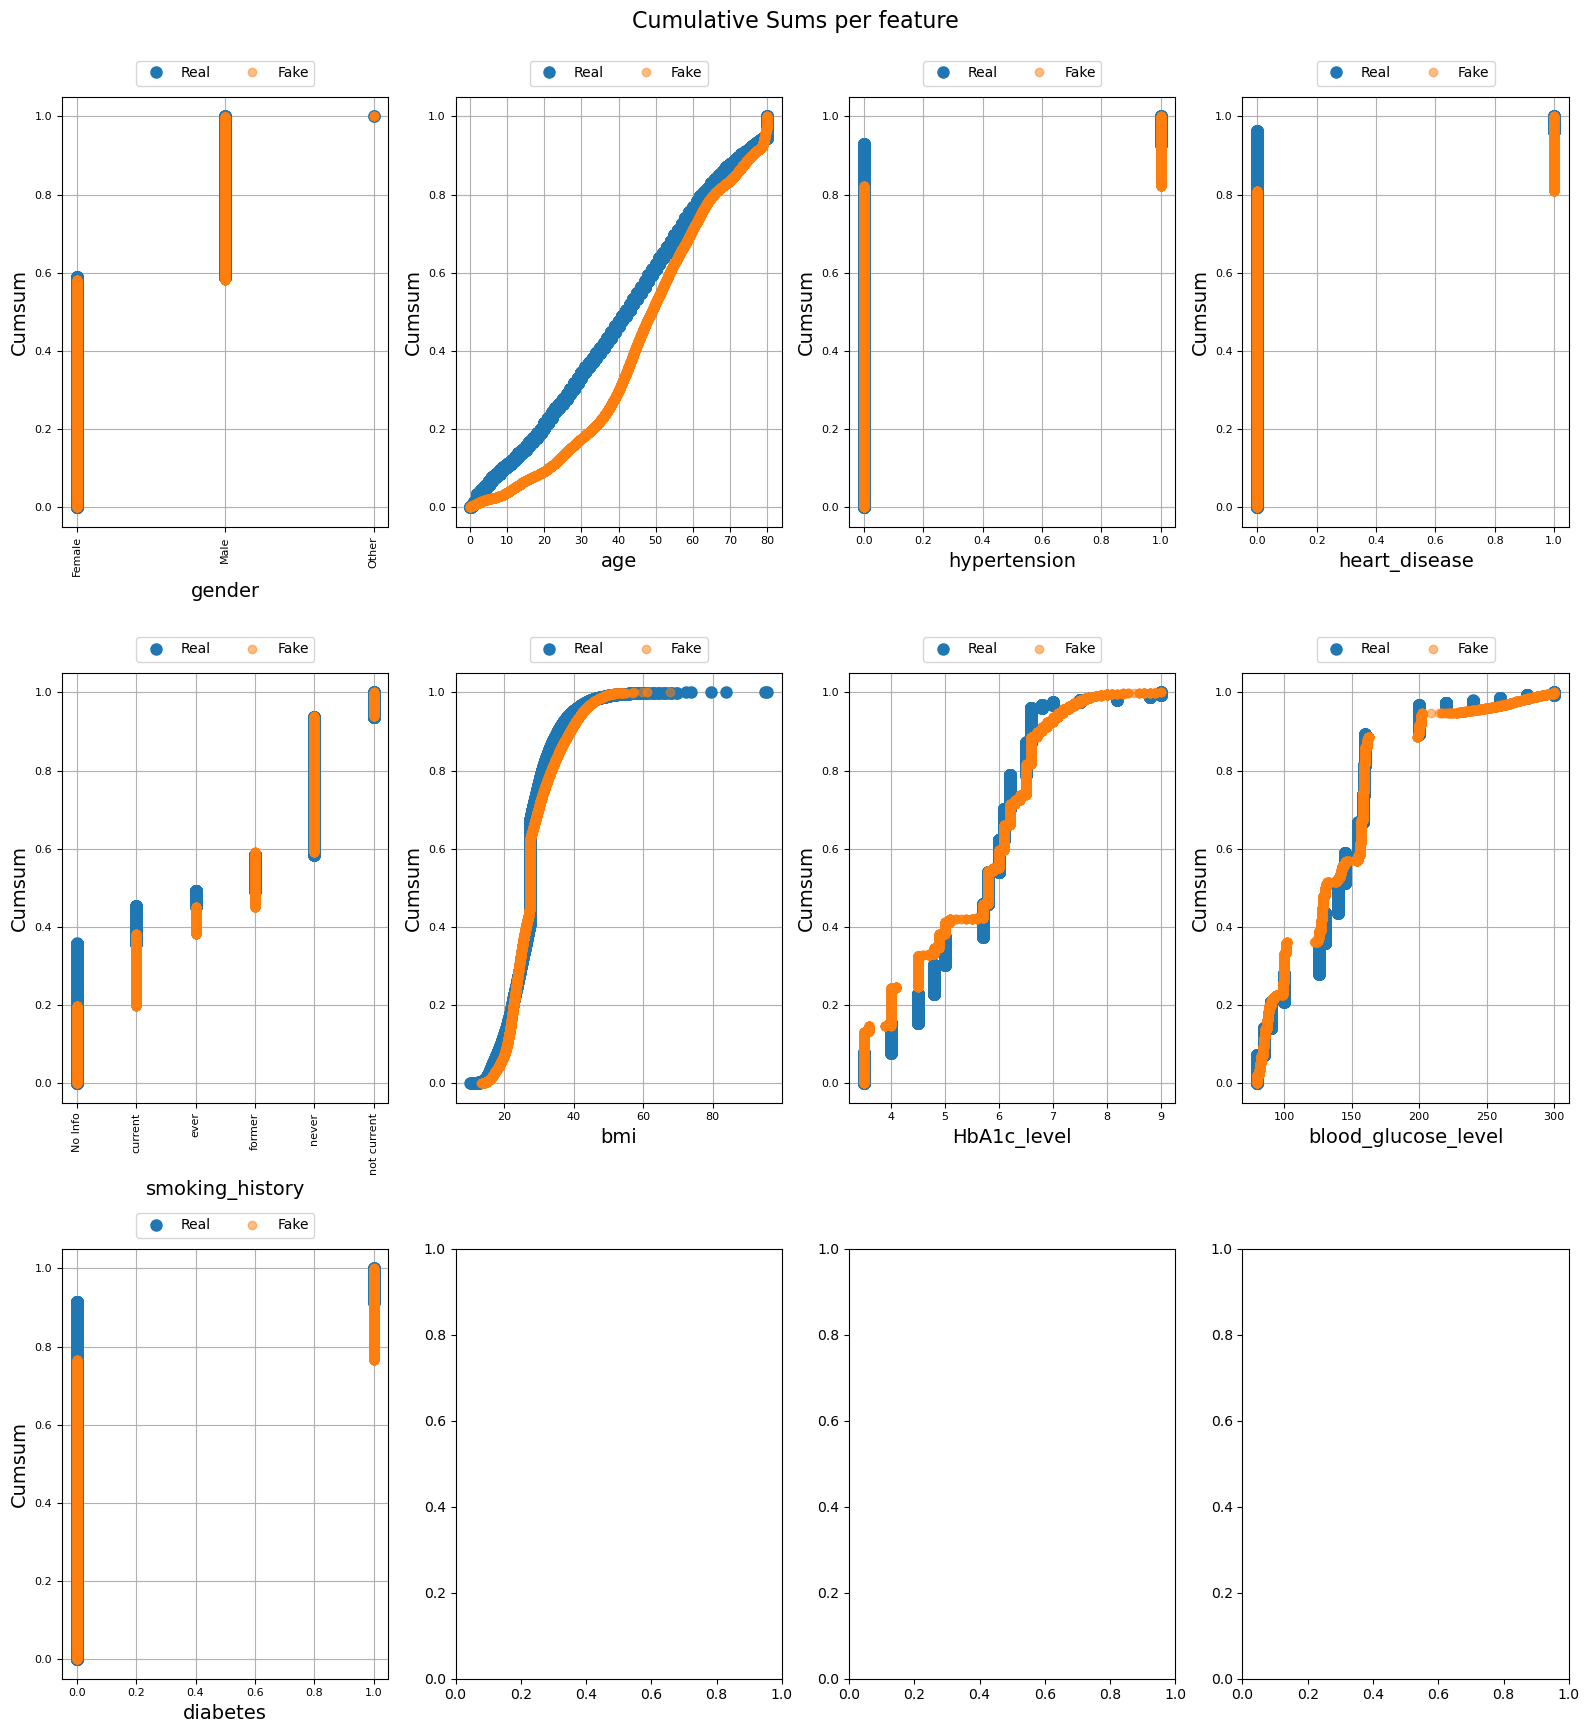

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



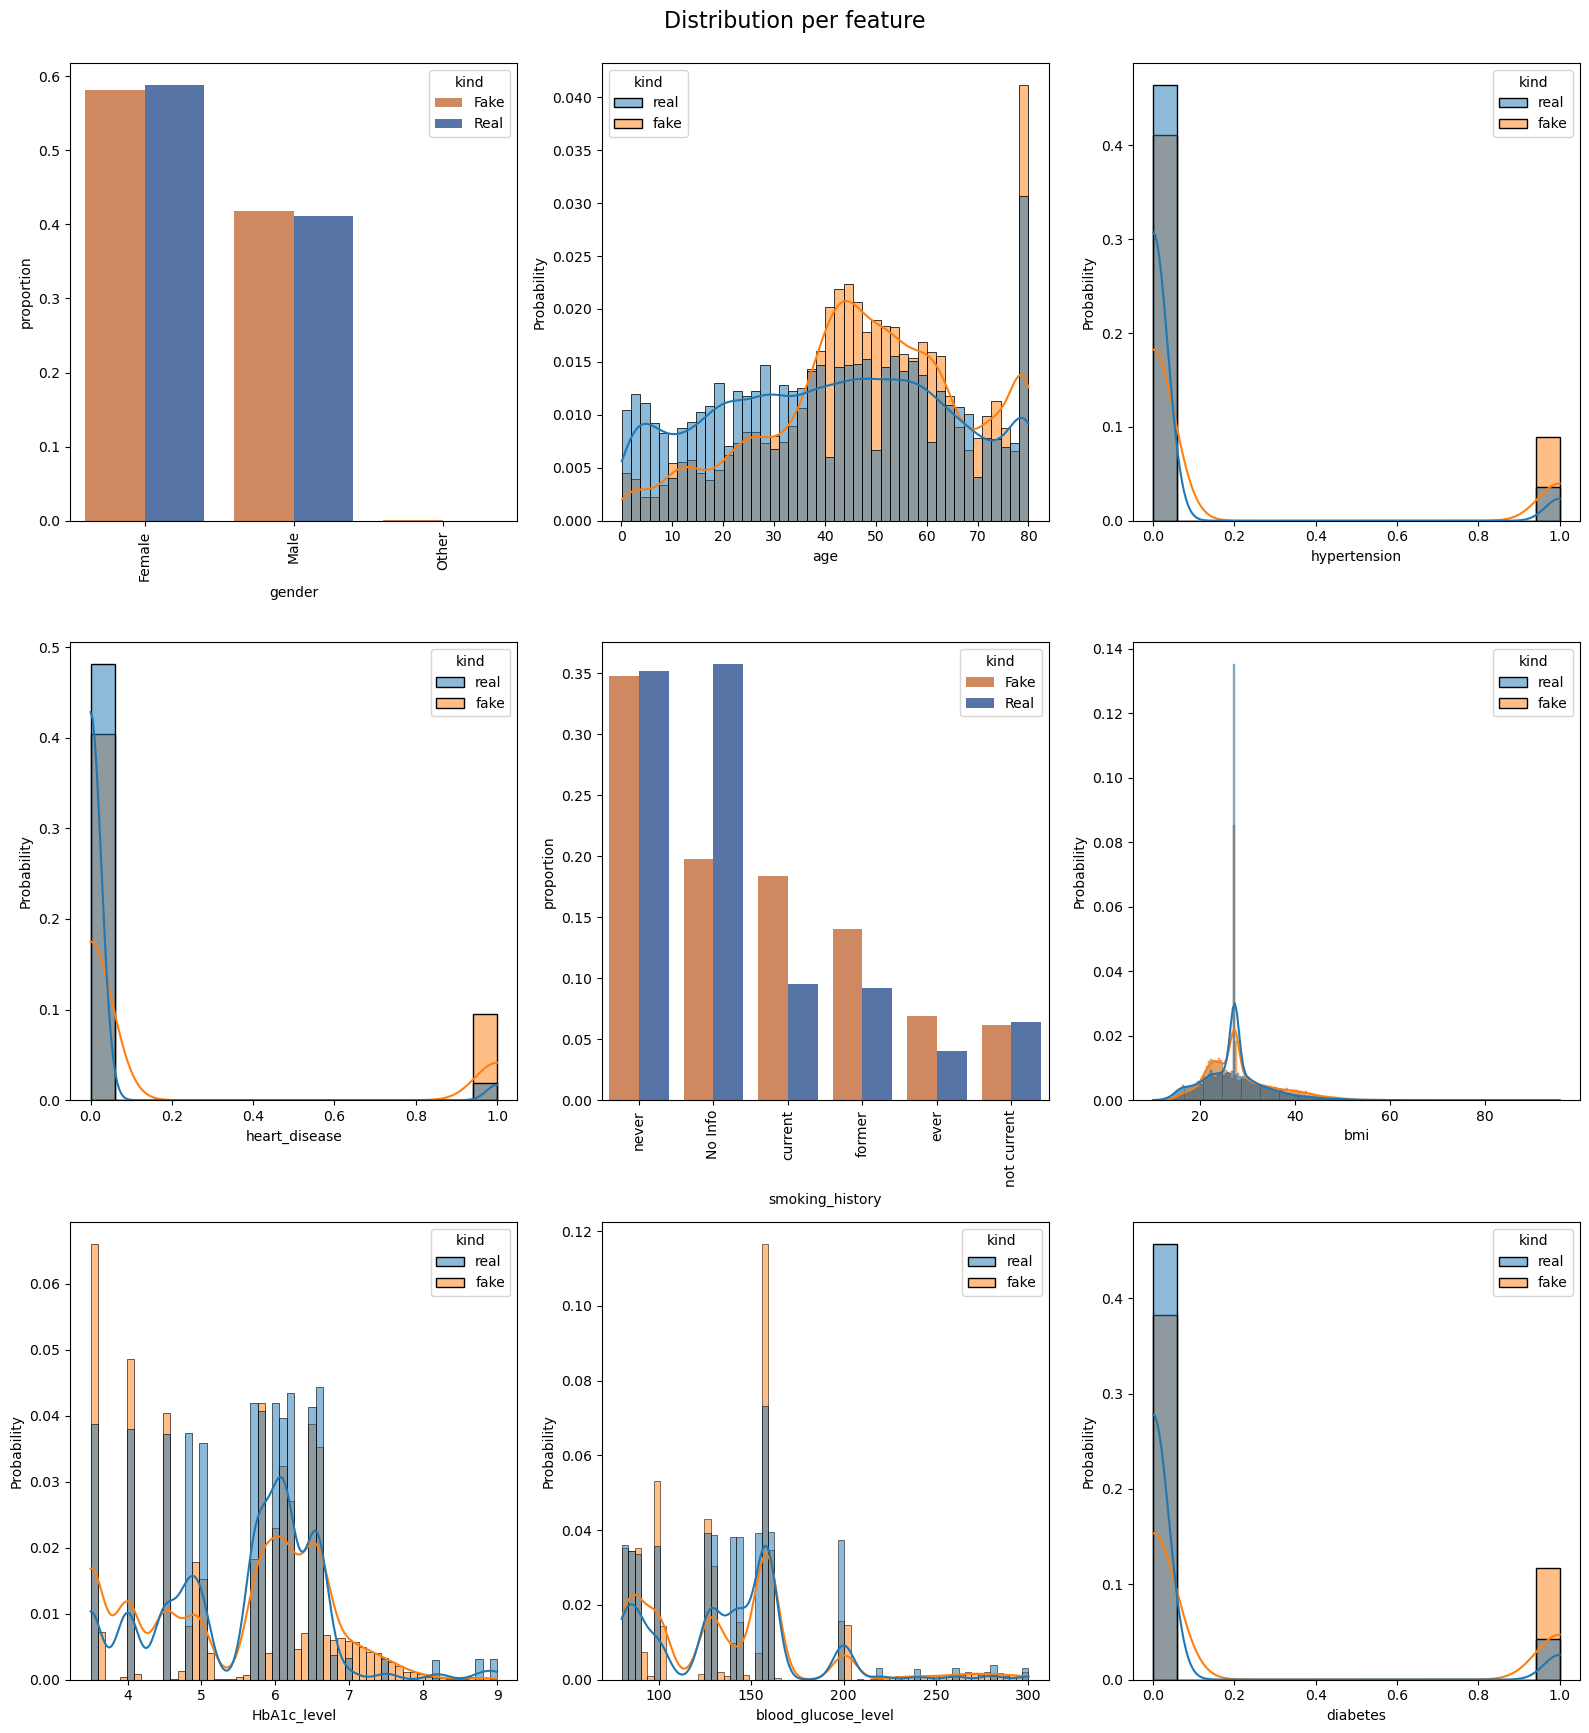

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython

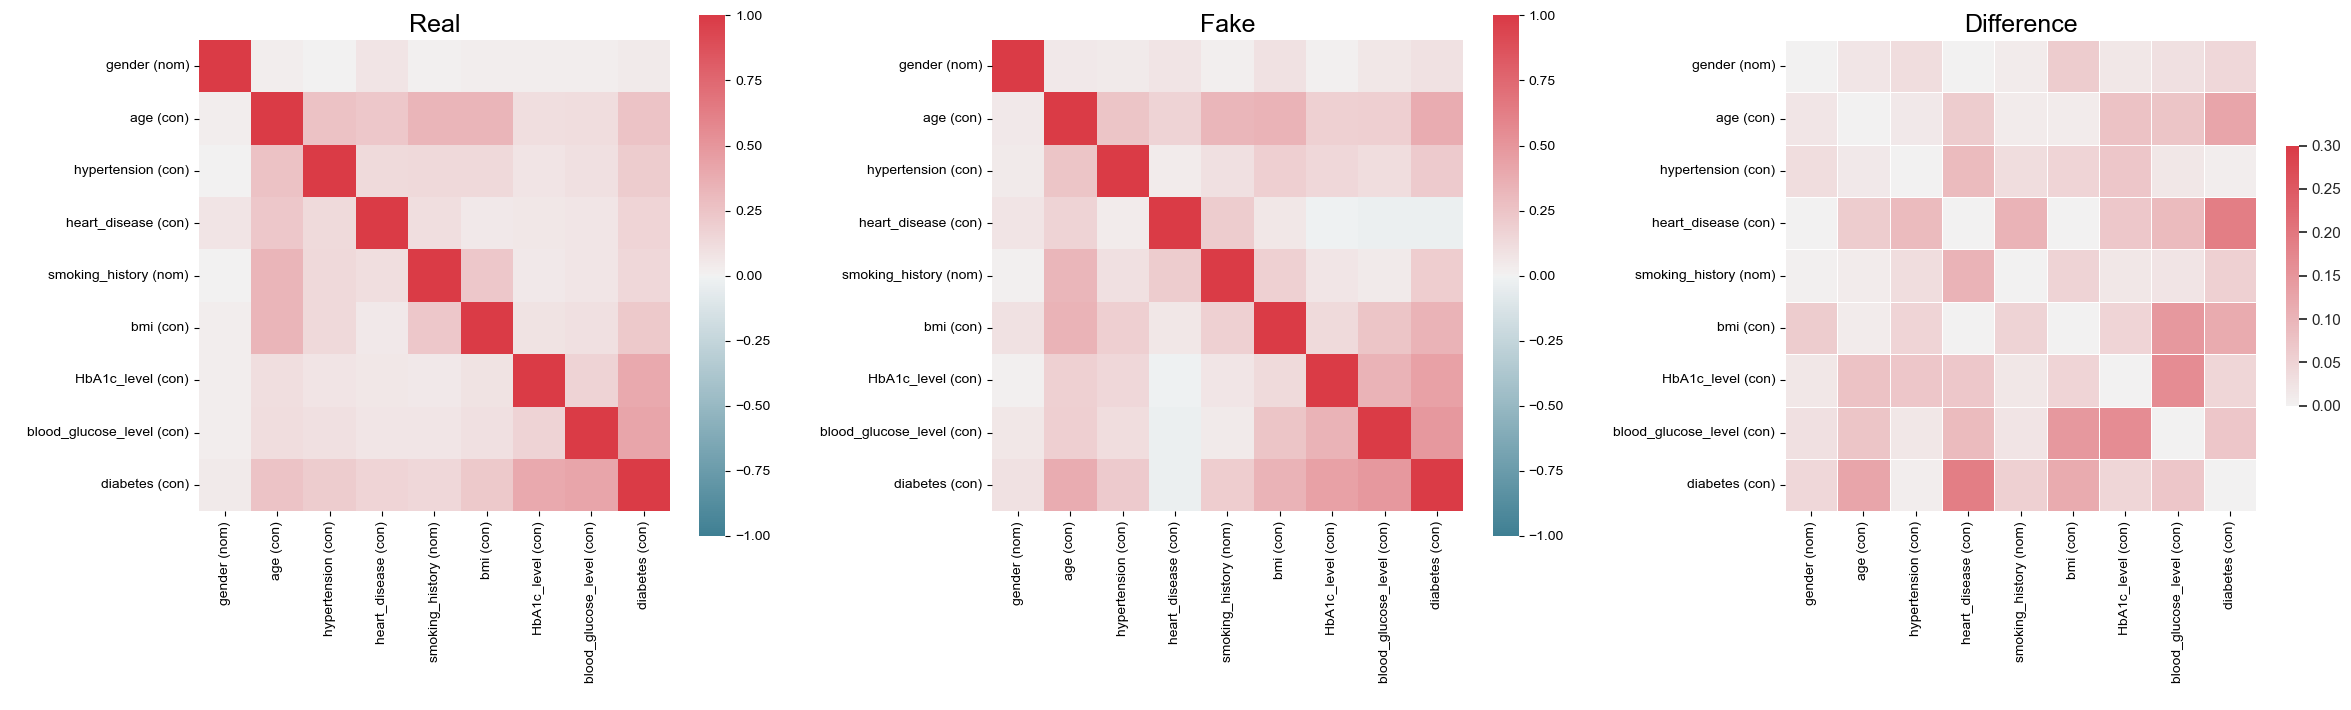

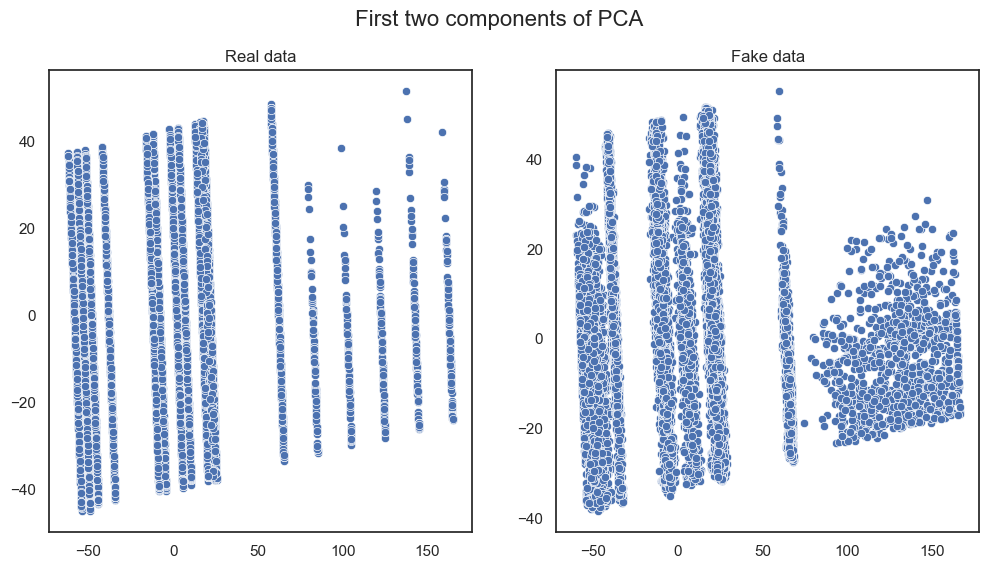

In [13]:
from table_evaluator import TableEvaluator
print(X_test.shape,samples.shape)
table_evaluator = TableEvaluator(X_test,samples)
table_evaluator.visual_evaluation()


In [15]:
table_evaluator.evaluate(target_col='smoking_history')

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.2435   0.2898              0.1343
DecisionTreeClassifier_real   0.3425   0.2725              0.1491
LogisticRegression_fake       0.3265   0.3797              0.5273
LogisticRegression_real       0.4145   0.3905              0.5060
MLPClassifier_fake            0.2890   0.3780              0.2983
MLPClassifier_real            0.4450   0.3830              0.2843
RandomForestClassifier_fake   0.2755   0.3438              0.1992
RandomForestClassifier_real   0.4002   0.3100              0.2149

Privacy results:
                                           result
Duplicate rows between sets (real/fake)  (378, 0)
nearest neighbor mean                      0.4455
nearest neighbor std                       0.3099

Miscellaneous results:
                                  Result
Co

### Comparing Testing Data and Synthetic Data vs Testing Data and Training Data

In [66]:
# Evaluating Wasserstein Distance
from scipy.stats import wasserstein_distance
wasserstein_distances = {}
for column in X_test.columns[5:]:
    wasserstein_dist = wasserstein_distance(X_test[column], samples[column])
    wasserstein_distances[column] = wasserstein_dist
# Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'Comparing Testing data and Synthetic Data {column}: {distance}')

Comparing Testing data and Synthetic Data bmi: 2.9651714999999994
Comparing Testing data and Synthetic Data HbA1c_level: 0.16635124999999998
Comparing Testing data and Synthetic Data blood_glucose_level: 14.598349999999998
Comparing Testing data and Synthetic Data diabetes: 0.12636249999999993


In [67]:
wasserstein_distances = {}
for column in X_test.columns[5:]:
    wasserstein_dist = wasserstein_distance(X_test[column], data[column])
    wasserstein_distances[column] = wasserstein_dist
# Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'Comparing Testing data and Training Data {column}: {distance}')

Comparing Testing data and Training Data bmi: 2.6594907500000002
Comparing Testing data and Training Data HbA1c_level: 0.197005
Comparing Testing data and Training Data blood_glucose_level: 8.760937499999997
Comparing Testing data and Training Data diabetes: 0.09488750000000001


In [68]:
# Calculate KL Divergence for each feature
from scipy.stats import entropy
kl_divergences = {}
for column in X_test.columns[5:]:
    kl_divergence = entropy(X_test[column], samples[:len(X_test)][column])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f'{column}: {divergence}')

bmi: 0.052669078170666773
HbA1c_level: 0.033920661901172086
blood_glucose_level: 0.07824392125172437
diabetes: inf


In [18]:
# Check for MSE and r2
from sklearn.metrics import mean_squared_error, r2_score
# Calculate MSE between testing_data and real_data
mse_real = mean_squared_error(X_test['bmi'], data[:len(X_test)]['bmi'])
print("MSE between Testing Data and Real Data:", mse_real)

# Calculate MSE between testing_data and synthetic_data
mse_synthetic = mean_squared_error(X_test['bmi'], samples[:len(X_test)]['bmi'])
print("MSE between Testing Data and Synthetic Data:", mse_synthetic)

# Calculate R-squared (R2) score
r2 = r2_score(X_test['bmi'], data[:len(X_test)]['bmi'])
print("R-squared Score (between Testing Data and Real Data):", r2)

r2 = r2_score(X_test['bmi'], samples[:len(X_test)]['bmi'])
print("R-squared Score (between Testing Data and Synthetic Data):", r2)

MSE between Testing Data and Real Data: 89.76393477
MSE between Testing Data and Synthetic Data: 95.46113928
R-squared Score (between Testing Data and Real Data): -0.9868047213716356
R-squared Score (between Testing Data and Synthetic Data): -1.1129047285525906
